In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.interpolate
import matplotlib.pyplot as plt

# The Black Scholes Formula
# CallorPut
# S - Stock price (known)
# K - Strike price (known)
# T - Time to maturity (known)
# r - Riskfree interest rate (can be found)
# d - Dividend yield (KNown(?))
# v - Volatility (given)

def BlackScholes(CallorPut, S, K, T, r, d, v):
    d1 = (np.log(float(S)/K)+((r-d) + v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1 - v*np.sqrt(T)
    
    if CallorPut == 'Call':
        return S*np.exp(-d*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-d*T)*norm.cdf(-d1)
    
##THIS WORKS DON'T TOUCH np

#bring in options data 
options = pd.read_csv('opt_port.csv')

opt_list=(0,1,2,3,4,5,6)
options['BS_Price'] = ""

for x in opt_list:
    maturity = (options.iloc[x, 1]/365)
    options.iloc[x, 11] = BlackScholes( options.iloc[x, 4], #callorput
                 options.loc[x, 'Spot'], #spot
                 options.loc[x, 'Strike'], #Strike
                 maturity, # T 
                 options.iloc[x, 2], #RF rate
                 0, #div yield
                 options.iloc[x, 8] #vol
                )
    
options

,Maturity,Days,RF rate,Underlying,PutorCall,BoughtSold,Number of Shares,Strike,Vol,Div Yield,Spot,BS_Price
0,9/12/2019,129,0.010187,BHP,Call,Bought,20000,39.0,0.2600,0.0414,38.78,2.35171
1,8/03/2020,219,0.009705,CBA,Put,Bought,15000,75.0,0.2798,0.0580,81.88,3.70921
2,12/04/2020,254,0.009443,CBA,Call,Bought,15000,75.0,0.2798,0.0580,81.88,11.5326
3,4/05/2020,276,0.009289,WESP,Put,Bought,25000,38.1,0.3056,0.0567,38.86,3.56053
4,7/08/2020,371,0.009026,WESP,Call,Bought,20000,39.0,0.3298,0.0567,38.86,5.22559
5,6/11/2020,462,0.008754,WPL,Call,Sold,10000,35.0,0.2845,0.0603,33.81,3.95955
6,6/12/2020,492,0.008665,WPL,Put,Bought,15000,33.0,0.2700,0.0603,33.81,3.56697


In [6]:
#bring in share data 
sharedata = pd.read_csv('RSKMShares.csv', index_col = 'Date', parse_dates = True)
sharedata.columns = [ 'ASX200', 'BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS']

#Get option data only 
opt_list_name = ('BHP', 'CBA', 'WESP', 'WPL')

Hist_opt_returns = pd.DataFrame()
for x in opt_list_name:
    Hist_opt_returns[x] = sharedata[x]
    
#calc returns
Hist_opt_returns = np.log(Hist_opt_returns).diff()
#drop first row NaN 
Hist_opt_returns = (Hist_opt_returns.drop(Hist_opt_returns.index[0]))

#simulated price change 
Sim_price_change = Hist_opt_returns * [38.78, 81.88, 38.86, 33.81]

#Spot + sim price change 
HS_Sim_Price = Sim_price_change + [38.78, 81.88, 38.86, 33.81]

#add in rows for CBA, WES & WPL as both have 2 options 
HS_Sim_Price.insert(2, 'CBA_2', HS_Sim_Price['CBA'])
HS_Sim_Price.insert(4, 'WESP_2', HS_Sim_Price['WESP'])
HS_Sim_Price.insert(6, 'WPL_2', HS_Sim_Price['WPL'])

HS_Sim_Price.head()

,BHP,CBA,CBA_2,WESP,WESP_2,WPL,WPL_2
Date,,,,,,,
2009-01-02,38.957919,82.725633,82.725633,38.206745,38.206745,34.358267,34.358267
2009-01-05,40.089255,80.180197,80.180197,39.513255,39.513255,34.233375,34.233375
2009-01-06,38.865714,84.333588,84.333588,39.671725,39.671725,34.553687,34.553687
2009-01-07,39.865673,80.422318,80.422318,41.098803,41.098803,33.949827,33.949827
2009-01-08,36.514407,80.769452,80.769452,37.250478,37.250478,31.705231,31.705231


In [7]:
#Chol matrix + random numbers 
share_log_returns = pd.DataFrame()
share_n = (0,1,2,3,4,5,6)
sharelist = ('BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS')
for x in sharelist:
    
    share_log_returns[x] = np.log(sharedata[x]).diff()
    
cov_matrix  = share_log_returns.cov()

chol = np.linalg.cholesky(cov_matrix)

#random numbers
rand_numbers = pd.DataFrame()
n_sims = 10000

for x in share_n:
    rand_numbers[x] = np.random.normal(0, 1, n_sims)
    
sim = []
outtest = []
for x in list(range(0, n_sims)):
    outtest = chol.dot(np.array(rand_numbers.loc[x, :]))
    sim.append(outtest)
    
#Calc simulated prices 
MC_sim_returns = pd.DataFrame(sim)
MC_sim_returns.columns = ['BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS']

MC_sim_price_change = MC_sim_returns * [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

MC_sim_price = MC_sim_price_change + [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

#Options
opt_list_name = ('BHP', 'CBA', 'WESP', 'WPL')

MC_opt_price = pd.DataFrame()
for x in opt_list_name:
    MC_opt_price[x] = MC_sim_price[x]
    
#insert clone columns
MC_opt_price.insert(2, 'CBA_2', MC_opt_price['CBA'])
MC_opt_price.insert(4, 'WESP_2', MC_opt_price['WESP'])
MC_opt_price.insert(6, 'WPL_2', MC_opt_price['WPL'])

In [8]:
MC_opt_price

,BHP,CBA,CBA_2,WESP,WESP_2,WPL,WPL_2
0,39.625430,82.422850,82.422850,38.196399,38.196399,34.221839,34.221839
1,39.236572,82.372765,82.372765,38.452562,38.452562,33.516986,33.516986
2,38.881805,80.355938,80.355938,38.127656,38.127656,33.298129,33.298129
3,38.455619,82.921504,82.921504,38.572408,38.572408,34.152102,34.152102
4,38.424218,82.585159,82.585159,38.920789,38.920789,34.037391,34.037391
5,38.466860,81.711928,81.711928,38.436737,38.436737,33.993808,33.993808
6,39.724185,82.387158,82.387158,39.256588,39.256588,34.380370,34.380370
7,39.919887,82.387864,82.387864,39.405812,39.405812,34.523033,34.523033
8,37.651712,80.759450,80.759450,38.667461,38.667461,32.747401,32.747401
9,38.435210,81.573897,81.573897,38.269603,38.269603,33.736430,33.736430


In [9]:
#Historical simulation of option prices 
opt_list=(0,1,2,3,4,5,6)
BS_MC_Sim = pd.DataFrame()
hist = list(range(0, 9999))

for y in hist:
    
    for x in opt_list:
        
        maturity = (options.iloc[x, 1]/365)
        
        BS_MC_Sim.loc[y,x] = BlackScholes( options.iloc[x, 4], #callorput
                 MC_opt_price.iloc[y, x], #spot
                 options.loc[x, 'Strike'], #Strike
                 maturity, # T 
                 options.iloc[x, 2], #RF rate
                 0, #div yield
                 options.loc[x, 'Vol'] #vol
                )
BS_MC_Sim

,0,1,2,3,4,5,6
0,2.819442,3.552162,11.914555,3.839402,4.852344,4.182773,3.408143
1,2.598518,3.566416,11.879089,3.729757,4.994816,3.804513,3.683705
2,2.405548,4.181147,10.489173,3.869257,4.814458,3.690793,3.772961
3,2.184748,3.412832,12.270085,3.679324,5.062168,4.144540,3.434610
4,2.168960,3.506298,12.029795,3.535819,5.260451,4.082034,3.478523
5,2.190416,3.758988,11.415373,3.736457,4.985956,4.058411,3.495331
6,2.877092,3.562315,11.889276,3.401803,5.455052,4.270340,3.348617
7,2.993162,3.562114,11.889776,3.343586,5.542614,4.349913,3.295803
8,1.801519,4.051640,10.761159,3.639715,5.115900,3.412585,4.005507
9,2.174479,3.800282,11.319520,3.807810,4.892851,3.920323,3.595983


In [10]:
MC_MtM = BS_MC_Sim * options['Number of Shares']
MC_MtM[5] = MC_MtM[5].apply(lambda x: x*-1)
MC_MtM

,0,1,2,3,4,5,6
0,56388.835570,53282.434952,178718.328733,95985.048129,97046.885323,-41827.727361,51122.148097
1,51970.357435,53496.238380,178186.335302,93243.924867,99896.326395,-38045.130687,55255.580695
2,48110.961995,62717.201637,157337.591602,96731.432453,96289.161425,-36907.933358,56594.412090
3,43694.959149,51192.480485,184051.269276,91983.109464,101243.368525,-41445.401328,51519.151503
4,43379.198432,52594.474963,180446.927845,88395.474955,105209.017864,-40820.339313,52177.845171
5,43808.316342,56384.814738,171230.591384,93411.429831,99719.124039,-40584.109505,52429.958576
6,57541.849162,53434.724196,178339.146170,85045.066943,109101.040609,-42703.396201,50229.247623
7,59863.240834,53431.707807,178346.644556,83589.639819,110852.280506,-43499.134191,49437.038758
8,36030.385691,60774.605395,161417.380733,90992.866424,102318.007157,-34125.854038,60082.605839
9,43489.586182,57004.223685,169792.794019,95195.258002,97857.019268,-39203.231541,53939.745414


In [11]:
PnL = pd.DataFrame(MC_MtM.sum(axis=1) - 483061.91)
PnL

,0
0,7654.043443
1,10941.722387
2,-2189.082156
3,-822.972924
4,-1679.310084
5,-6661.784595
6,7925.768502
7,8959.508091
8,-5571.912799
9,-4986.514971


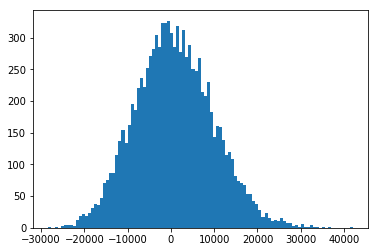

In [25]:
MCPnL = np.array(PnL)
MCPnL.sort
plt.hist(MCPnL, bins=100);
np.percentile(MCPnL, 5)
option_var = np.percentile(MCPnL, 5)

In [13]:
#historical Sim of shares 

'''share_list_name = ('BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS')

Hist_share_returns = pd.DataFrame()
for x in share_list_name:
    Hist_share_returns[x] = sharedata[x]
    
#calc returns
Hist_share_returns = np.log(Hist_share_returns).diff()
#drop first row NaN 
Hist_share_returns = (Hist_share_returns.drop(Hist_share_returns.index[0]))

#simulated price change 
Sim_price_change = Hist_share_returns * [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

#Spot + sim price change 
HS_Sim_Price = Sim_price_change + [38.78,94.77,81.88,38.86,33.81,28.51,3.98]'''

#Short poitions
shorts = ['WESP', 'NAB', 'TLS']

for y in shorts:
    MC_sim_price[y] = MC_sim_price[y].apply(lambda x: x*-1)

#Portfolio 
MC_Port = MC_sim_price * [5000,3000,4000,10000,5000,15000,30000]
#Sim portfolio - portfolio 
#PnL_stock = pd.DataFrame(MC_Port.sum(axis=1)- 39130)

In [14]:
PnL_stock = pd.DataFrame(MC_Port.sum(axis=1)- 39130)
PnL_stock

,0
0,8850.517283
1,13639.547476
2,4469.869993
3,765.214564
4,-9637.171100
5,2967.404670
6,6241.711385
7,1801.380996
8,-17619.386842
9,784.474992


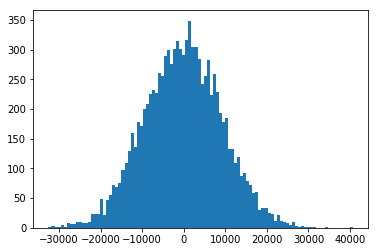

In [24]:
MCPnL_stock = np.array(PnL_stock)
MCPnL_stock.sort
plt.hist(MCPnL_stock, bins=100);
np.percentile(MCPnL_stock, 5)
stock_var = np.percentile(MCPnL_stock, 5)

In [16]:
stock_var + option_var

-28910.153398281494

In [17]:
option_var

-13554.95605509837

In [18]:
stock_var

-15355.197343183125

In [26]:
np.percentile(MCPnL_stock, 1) + np.percentile(MCPnL, 1)

-40733.44503368165

In [28]:
MCPnL[MCPnL <= np.percentile(MCPnL, 5)].mean() + MCPnL_stock[MCPnL_stock <= np.percentile(MCPnL_stock, 5)].mean()

-36077.289838183206